In [188]:
import xarray as xr
import numpy as np
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook as tqdm

In [2]:
DATA_DIR = '/local/S.Rasp/ML-Workshop-Data/dataset2/'

In [4]:
!ls $DATA_DIR

forecast_errors.png  nwp_ecmwf-ifs.nc	power_curve_single_turbine.png
metobs.nc	     nwp_envca-gdps.nc	README.md
ml_workshop_data.7z  nwp_ncep-gfs4.nc	windpark.nc


## Check out the data

### NWP data

In [35]:
nwp_ec = xr.open_dataset(DATA_DIR + 'nwp_ecmwf-ifs.nc')
nwp_en = xr.open_dataset(DATA_DIR + 'nwp_envca-gdps.nc')
nwp_nc = xr.open_dataset(DATA_DIR + 'nwp_ncep-gfs4.nc')

In [38]:
nwps = [nwp_ec, nwp_en, nwp_nc]
nwps

[<xarray.Dataset>
 Dimensions:   (epoch_s: 1463, offset_s: 49)
 Coordinates:
   * epoch_s   (epoch_s) int32 1420070400 1420113600 1420156800 1420200000 ...
   * offset_s  (offset_s) int32 0 10800 21600 32400 43200 54000 64800 75600 ...
 Data variables:
     ws100m    (epoch_s, offset_s) float32 ...
     wd100m    (epoch_s, offset_s) float32 ...
     ws10m     (epoch_s, offset_s) float32 ...
     wd10m     (epoch_s, offset_s) float32 ...
     t2m       (epoch_s, offset_s) float32 ...
     blh       (epoch_s, offset_s) float32 ..., <xarray.Dataset>
 Dimensions:   (epoch_s: 1463, offset_s: 49)
 Coordinates:
   * epoch_s   (epoch_s) int32 1420070400 1420113600 1420156800 1420200000 ...
   * offset_s  (offset_s) int32 0 10800 21600 32400 43200 54000 64800 75600 ...
 Data variables:
     ws1000mb  (epoch_s, offset_s) float32 ...
     wd1000mb  (epoch_s, offset_s) float32 ...
     ws925mb   (epoch_s, offset_s) float32 ...
     wd925mb   (epoch_s, offset_s) float32 ...
     tclcov    (epoch_s,

In [43]:
# Convert POSIX to datetime
for nwp in nwps:
    nwp['epoch_s'] = pd.to_datetime(nwp.epoch_s, unit='s')

In [44]:
nwps

[<xarray.Dataset>
 Dimensions:   (epoch_s: 1463, offset_s: 49)
 Coordinates:
   * epoch_s   (epoch_s) datetime64[ns] 2015-01-01 2015-01-01T12:00:00 ...
   * offset_s  (offset_s) int32 0 10800 21600 32400 43200 54000 64800 75600 ...
 Data variables:
     ws100m    (epoch_s, offset_s) float32 ...
     wd100m    (epoch_s, offset_s) float32 ...
     ws10m     (epoch_s, offset_s) float32 ...
     wd10m     (epoch_s, offset_s) float32 ...
     t2m       (epoch_s, offset_s) float32 ...
     blh       (epoch_s, offset_s) float32 ..., <xarray.Dataset>
 Dimensions:   (epoch_s: 1463, offset_s: 49)
 Coordinates:
   * epoch_s   (epoch_s) datetime64[ns] 2015-01-01 2015-01-01T12:00:00 ...
   * offset_s  (offset_s) int32 0 10800 21600 32400 43200 54000 64800 75600 ...
 Data variables:
     ws1000mb  (epoch_s, offset_s) float32 ...
     wd1000mb  (epoch_s, offset_s) float32 ...
     ws925mb   (epoch_s, offset_s) float32 ...
     wd925mb   (epoch_s, offset_s) float32 ...
     tclcov    (epoch_s, offset_

In [45]:
for nwp in nwps:
    print(nwp.epoch_s.min(), nwp.epoch_s.max())

<xarray.DataArray 'epoch_s' ()>
array('2015-01-01T00:00:00.000000000', dtype='datetime64[ns]') <xarray.DataArray 'epoch_s' ()>
array('2017-01-01T00:00:00.000000000', dtype='datetime64[ns]')
<xarray.DataArray 'epoch_s' ()>
array('2015-01-01T00:00:00.000000000', dtype='datetime64[ns]') <xarray.DataArray 'epoch_s' ()>
array('2017-01-01T00:00:00.000000000', dtype='datetime64[ns]')
<xarray.DataArray 'epoch_s' ()>
array('2015-01-01T00:00:00.000000000', dtype='datetime64[ns]') <xarray.DataArray 'epoch_s' ()>
array('2017-01-01T00:00:00.000000000', dtype='datetime64[ns]')


In [110]:
nwp_ec.offset_s.max() / 60 / 60, (nwp_ec.offset_s[1] - nwp_ec.offset_s[0]) / 60

(<xarray.DataArray 'offset_s' ()>
 array(144.), <xarray.DataArray 'offset_s' ()>
 array(180.))

In [107]:
4*24

96

## Mast data

In [48]:
met = xr.open_dataset(DATA_DIR + 'metobs.nc'); met

<xarray.Dataset>
Dimensions:  (epoch_s: 63072)
Coordinates:
  * epoch_s  (epoch_s) int32 1420070400 1420071300 1420072200 1420073100 ...
Data variables:
    ws_avg   (epoch_s) float32 ...
    wd_avg   (epoch_s) float32 ...
    ws80m    (epoch_s) float32 ...
    ws34m    (epoch_s) float32 ...

In [49]:
# Convert to date time
met['epoch_s'] = pd.to_datetime(met.epoch_s, unit='s')

In [61]:
met.epoch_s.min(), met.epoch_s.max(), met.epoch_s[1] - met.epoch_s[0]

(<xarray.DataArray 'epoch_s' ()>
 array('2015-01-01T00:00:00.000000000', dtype='datetime64[ns]'),
 <xarray.DataArray 'epoch_s' ()>
 array('2016-10-18T23:45:00.000000000', dtype='datetime64[ns]'),
 <xarray.DataArray 'epoch_s' ()>
 array(900000000000, dtype='timedelta64[ns]'))

In [63]:
900000000000 / 1e9 / 60

15.0

## Target wind production data

In [64]:
pwr = xr.open_dataset(DATA_DIR + 'windpark.nc'); pwr

<xarray.Dataset>
Dimensions:   (epoch_s: 94608)
Coordinates:
  * epoch_s   (epoch_s) int32 1420070400 1420071000 1420071600 1420072200 ...
Data variables:
    power     (epoch_s) float32 ...
    rawpower  (epoch_s) float32 ...

In [65]:
# Convert to date time
pwr['epoch_s'] = pd.to_datetime(pwr.epoch_s, unit='s')

In [66]:
pwr.epoch_s.min(), pwr.epoch_s.max(), pwr.epoch_s[1] - pwr.epoch_s[0]

(<xarray.DataArray 'epoch_s' ()>
 array('2015-01-01T00:00:00.000000000', dtype='datetime64[ns]'),
 <xarray.DataArray 'epoch_s' ()>
 array('2016-10-18T23:50:00.000000000', dtype='datetime64[ns]'),
 <xarray.DataArray 'epoch_s' ()>
 array(600000000000, dtype='timedelta64[ns]'))

In [67]:
600000000000 / 1e9 / 60

10.0

## EDA

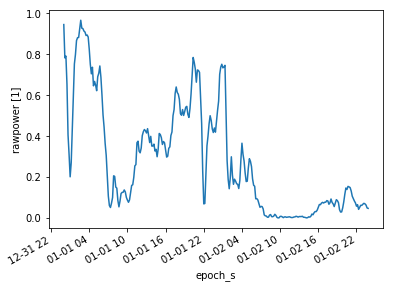

In [73]:
pwr.rawpower.sel(epoch_s=slice('2015-01-01', '2015-01-02')).plot()

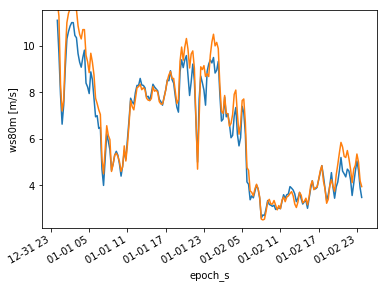

In [76]:
met.ws34m.sel(epoch_s=slice('2015-01-01', '2015-01-02')).plot()
met.ws80m.sel(epoch_s=slice('2015-01-01', '2015-01-02')).plot()

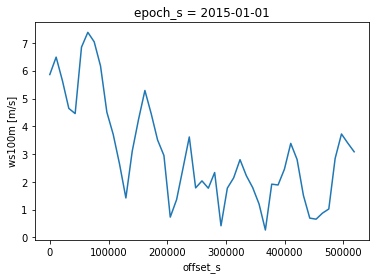

In [86]:
nwp_ec.ws100m.sel(epoch_s='2015-01-01T00').plot()

### Wind farm power curve

In [97]:
intersect = np.intersect1d(met.epoch_s, pwr.epoch_s)

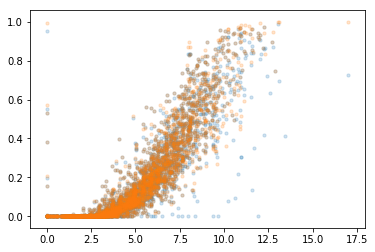

In [106]:
plt.scatter(met.ws34m.sel(epoch_s=intersect[::10]), pwr.rawpower.sel(epoch_s=intersect[::10]), s=10, alpha=0.2)
plt.scatter(met.ws34m.sel(epoch_s=intersect[::10]), pwr.power.sel(epoch_s=intersect[::10]), s=10, alpha=0.2)

## Split into datasets and prepare

total roughly 22 months

In [119]:
train_range = slice('2015-01-01', '2015-12-31')
valid_range = slice('2016-01-01', '2016-04-30')
test_range = slice('2016-05-01', '2016-10-18T23:50')

In [120]:
def split(ds):
    return ds.sel(epoch_s=train_range), ds.sel(epoch_s=valid_range), ds.sel(epoch_s=test_range)

### Option 1: Latest available NWP

In [123]:
nwp_ec

<xarray.Dataset>
Dimensions:   (epoch_s: 1463, offset_s: 49)
Coordinates:
  * epoch_s   (epoch_s) datetime64[ns] 2015-01-01 2015-01-01T12:00:00 ...
  * offset_s  (offset_s) int32 0 10800 21600 32400 43200 54000 64800 75600 ...
Data variables:
    ws100m    (epoch_s, offset_s) float32 5.862752 6.4898725 5.634605 ...
    wd100m    (epoch_s, offset_s) float32 ...
    ws10m     (epoch_s, offset_s) float32 ...
    wd10m     (epoch_s, offset_s) float32 ...
    t2m       (epoch_s, offset_s) float32 ...
    blh       (epoch_s, offset_s) float32 ...

In [190]:
fc_lead = np.timedelta64(4*24*60*60+1, 's')

In [191]:
every_3_hours = np.arange('2015-01-01', np.datetime64('2016-10-18T23:50')-fc_lead, 
                          np.timedelta64(3, 'h'), dtype='datetime64[ns]')

In [198]:
train_range.start

'2015-01-01'

In [138]:
t = every_3_hours[1]; t

numpy.datetime64('2015-01-01T03:00:00.000000000')

In [141]:
e = nwp_ec.sel(epoch_s=t, method='ffill'); e

<xarray.Dataset>
Dimensions:   (offset_s: 49)
Coordinates:
    epoch_s   datetime64[ns] 2015-01-01
  * offset_s  (offset_s) int32 0 10800 21600 32400 43200 54000 64800 75600 ...
Data variables:
    ws100m    (offset_s) float32 5.862752 6.4898725 5.634605 4.6443353 ...
    wd100m    (offset_s) float32 ...
    ws10m     (offset_s) float32 ...
    wd10m     (offset_s) float32 ...
    t2m       (offset_s) float32 ...
    blh       (offset_s) float32 ...

In [154]:
offset = int(t - e.epoch_s) / 1e9; offset

10800.0

In [155]:
fc_lead = 4*24*60*60

In [162]:
e = e.sel(offset_s=slice(offset, offset+fc_lead))

In [167]:
for v in e.data_vars:
    print(e[v].values)

[6.4898725 5.634605  4.6443353 4.4582396 6.848489  7.382034  7.041829
 6.1719995 4.508078  3.7102172 2.6415453 1.4213299 3.103512  4.2527385
 5.2897115 4.4467044 3.5077186 2.9493427 0.732437  1.3627146 2.4827392
 3.61633   1.7838506 2.0357404 1.7722827 2.3367822 0.4201571 1.7750397
 2.1468422 2.8002076 2.2207377 1.7930771 1.2054965]
[355.0636    352.50848   342.34384     4.974042   20.016277   19.414217
  11.665945    3.4725168 346.6009    352.69174   340.15317    21.288338
  68.77709    52.387917   22.23334   357.7804    348.8169    347.56473
 328.63144   116.98958    85.32323    57.820568   50.745415   13.221746
 338.71487   338.63483   184.17598   124.33079    95.5627     84.56578
  61.264797  349.97922   345.96017  ]
[4.9153886 3.9240022 3.158168  3.8089957 5.693307  6.216066  5.7073874
 4.6632237 3.0033753 2.3157218 1.7537808 1.3022597 3.0725126 3.901163
 4.4058676 3.414275  2.1812153 1.9324714 0.5561029 1.415275  2.477819
 3.4498005 1.9555744 1.8426445 1.199936  1.336043  0.49773

In [168]:
def get_latest_fc(t, nwps, flatten=True):
    a = []
    for nwp in nwps:
        e = nwp_ec.sel(epoch_s=t, method='ffill')
        offset = int(t - e.epoch_s) / 1e9
        fc_lead = 4*24*60*60
        e = e.sel(offset_s=slice(offset, offset+fc_lead))
        for v in e.data_vars:
            a.append(e[v].values)
    a = np.array(a)
    return a.reshape(-1) if flatten else a

In [173]:
t

numpy.datetime64('2015-01-01T03:00:00.000000000')

In [180]:
fc_lead = np.timedelta64(4*24*60*60+1, 's')
time_idxs = np.arange(t, t+fc_lead, np.timedelta64(3, 'h'), dtype='datetime64[ns]')

In [181]:
pwr.rawpower.sel(epoch_s=time_idxs)

<xarray.DataArray 'rawpower' (epoch_s: 33)>
array([9.260957e-01, 6.019239e-01, 1.195000e-01, 3.186761e-01, 4.132283e-01,
       6.049913e-01, 7.238174e-01, 4.753239e-01, 1.804087e-01, 1.552022e-01,
       9.404348e-03, 2.602174e-03, 1.946522e-02, 9.296957e-02, 1.487261e-01,
       5.253478e-02, 1.043478e-04, 0.000000e+00, 0.000000e+00, 5.000000e-04,
       0.000000e+00, 1.742391e-02, 1.019739e-01, 0.000000e+00, 1.091522e-02,
       0.000000e+00, 0.000000e+00, 0.000000e+00, 1.272391e-02, 1.611087e-02,
       1.593478e-03, 0.000000e+00, 0.000000e+00], dtype=float32)
Coordinates:
  * epoch_s  (epoch_s) datetime64[ns] 2015-01-01T03:00:00 ...
Attributes:
    descr:    raw normalized wind park power output
    units:    1

In [184]:
def get_y(t, dt=np.timedelta64(3, 'h')):
    fc_lead = np.timedelta64(4*24*60*60+1, 's')
    time_idxs = np.arange(t, t+fc_lead, np.timedelta64(3, 'h'), dtype='datetime64[ns]')
    return pwr.rawpower.sel(epoch_s=time_idxs).values

In [200]:
every_3_hours[(every_3_hours >= np.datetime64(train_range.start)) & (every_3_hours <= np.datetime64(train_range.stop))]

array(['2015-01-01T00:00:00.000000000', '2015-01-01T03:00:00.000000000',
       '2015-01-01T06:00:00.000000000', ...,
       '2015-12-30T18:00:00.000000000', '2015-12-30T21:00:00.000000000',
       '2015-12-31T00:00:00.000000000'], dtype='datetime64[ns]')

In [202]:
X_train = []
y_train = []
every_3_hours_train = every_3_hours[(every_3_hours >= np.datetime64(train_range.start)) & 
                                    (every_3_hours <= np.datetime64(train_range.stop))]
for t in tqdm(every_3_hours_train):
    X_train.append(get_latest_fc(t, nwps))
    y_train.append(get_y(t))

In [203]:
X_valid = []
y_valid = []
every_3_hours_valid = every_3_hours[(every_3_hours >= np.datetime64(valid_range.start)) & 
                                    (every_3_hours <= np.datetime64(valid_range.stop))]
for t in tqdm(every_3_hours_valid):
    X_valid.append(get_latest_fc(t, nwps))
    y_valid.append(get_y(t))

In [204]:
X_train, y_train = np.array(X_train), np.array(y_train)
X_valid, y_valid = np.array(X_valid), np.array(y_valid)
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((2913, 594), (2913, 33), (961, 594), (961, 33))

## Linear regression

In [206]:
#normalize
mean, std = X_train.mean(0), X_train.std(0)
X_train = (X_train - mean) / std
X_valid = (X_valid - mean) / std

In [207]:
from sklearn.linear_model import LinearRegression

In [208]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [209]:
lr.score(X_train, y_train)

0.5663079412330208

In [210]:
lr.score(X_valid, y_valid)

0.27583495425890764

In [216]:
def mse(y_true, y_pred, axis=(0,1)): return ((y_true - y_pred)**2).mean(axis)

In [212]:
mse(y_valid, lr.predict(X_valid))

0.02931417

In [215]:
mse(y_valid, np.ones(y_valid.shape) * y_train.mean())

0.04397855413106132

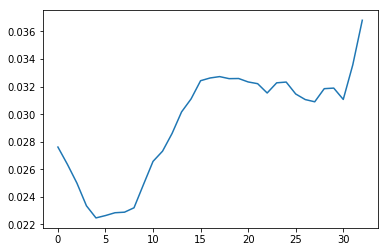

In [219]:
plt.plot(mse(y_valid, lr.predict(X_valid), 0))

## Random forest

In [220]:
from sklearn.ensemble import RandomForestRegressor

In [221]:
rf = RandomForestRegressor(n_estimators=40, n_jobs=-1, min_samples_leaf=10)

In [222]:
%time rf.fit(X_train, y_train)

CPU times: user 2min, sys: 24 ms, total: 2min
Wall time: 6.86 s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=10, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [224]:
rf.score(X_train, y_train), rf.score(X_valid, y_valid)

(0.5945155563435212, 0.4401730187225384)

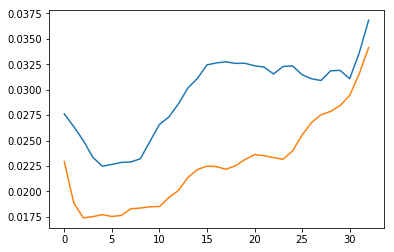

In [225]:
plt.plot(mse(y_valid, lr.predict(X_valid), 0))
plt.plot(mse(y_valid, rf.predict(X_valid), 0))

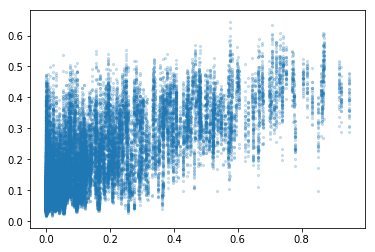

In [228]:
plt.scatter(y_valid, rf.predict(X_valid), s=5, alpha=0.2)